# Descriptive analytics

# Temporal Demand Patterns & Seasonality # Lina
- Pro Tag / Pro Woche / Pro Monat / Pro Jahr 
- Mit Wetterdaten vergleichen
 

## Geographical Demand Patterns # Nico, Jieyu
## ? Pro Stadtteil angemeldete Autos
## Altersgruppen je Stadtteil -> Zusammenhang zu Abo Modellen
## Pass -> Häufig für den Arbeitsweg? (RoundTrip, OneWay, Zeiten)

## KPIs
- Aktuelle Auslastung (Live & Historisch, Pro Station) (-> Mehr Stationen, Fahrräder?) # Lukas 
- Ausfall/Probleme: (Wartungsaufwand (z.B. in Prozent available/not available), ) # Ange
- Umsatz durch "Minutengeld" # Marc
- Anteil an Arten von Passhaltern?
- Anteil von Tripcategories?


In [1]:
import numpy as np
import pandas as pd


import matplotlib
import matplotlib.pyplot as pp
import seaborn as sns

import glob

%matplotlib inline
%config IPCompleter.greedy=True

## preparing & cleaning data



In [2]:
csv_files = glob.glob('Datasets/RideIndego 2016/*.csv')
df = pd.concat([pd.read_csv(f) for f  in csv_files], ignore_index = True)

### Find out NaN Values

In [3]:
df.isna().sum()

trip_id                   0
duration                  0
start_time                0
end_time                  0
start_station_id         10
start_lat                17
start_lon                17
end_station_id            0
end_lat                1591
end_lon                1591
bike_id                   0
plan_duration             0
trip_route_category       0
passholder_type           0
dtype: int64

### Drop any Row with NaN 0 in end_lat end_lon



In [4]:
df['start_lat'] = pd.to_numeric(df['start_lat'], errors='coerce')
df['start_lon'] = pd.to_numeric(df['start_lon'], errors='coerce')
df['start_station_id'] = pd.to_numeric(df['start_station_id'], errors='coerce')
df['end_station_id'] = pd.to_numeric(df['end_station_id'], errors='coerce')
df['end_lat'] = pd.to_numeric(df['end_lat'], errors='coerce')
df['end_lon'] = pd.to_numeric(df['end_lon'], errors='coerce')
df['bike_id'] = pd.to_numeric(df['bike_id'], errors='coerce')
df['plan_duration'] = pd.to_numeric(df['plan_duration'], errors='coerce')

In [5]:
df.isna().sum()

trip_id                   0
duration                  0
start_time                0
end_time                  0
start_station_id         10
start_lat                69
start_lon                69
end_station_id            0
end_lat                3023
end_lon                3023
bike_id                   0
plan_duration             0
trip_route_category       0
passholder_type           0
dtype: int64

In [65]:
df = df.dropna(how='any').reset_index(drop=True)
df1 = df

## Unique Bike Stations

In [7]:
len(df.groupby(['start_station_id']))

106

# Integration of the weather data (Marc)

In [8]:
#import weather data
#STR_Nov = pd.read_csv("Car2Go_STR_SampleData.csv", encoding = "ISO-8859-1")
weather = pd.read_csv('weather_hourly_philadelphia.csv')

In [9]:
weather.head()

,date_time,max_temp,min_temp,precip
0,2015-01-02 01:00:00,3.3,3.3,0.0
1,2015-01-02 02:00:00,2.8,2.8,0.0
2,2015-01-02 03:00:00,2.2,2.2,0.0
3,2015-01-02 04:00:00,0.6,0.6,0.0
4,2015-01-02 05:00:00,1.1,1.1,0.0


In [10]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43848 entries, 0 to 43847
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date_time  43785 non-null  object 
 1   max_temp   43785 non-null  float64
 2   min_temp   43785 non-null  float64
 3   precip     43785 non-null  float64
dtypes: float64(3), object(1)
memory usage: 1.3+ MB


Prepare weather data to make it usable for our tasks:


In [11]:
weather['date_time'] = pd.to_datetime(weather['date_time'])

In [12]:
weather['date_hour'] = weather['date_time'].dt.strftime('%m-%d-%h')


Combine both dataframes into one using mapping:

In [13]:
# have to use something else than a full merge as it duplicates everything from df
#df_weather = pd.merge(df, weather, on="date_hour") 

In [14]:
#quick inspection:
#df_weather.info()
#df_weather.head()
#one could consider dropping some columns to make it more readable

### Further Inspectation of data to prepare descriptive analysis (Marc)


In [15]:
df.describe()

,trip_id,duration,start_station_id,start_lat,start_lon,end_station_id,end_lat,end_lon,bike_id,plan_duration
count,6.519710e+05,651971.000000,651971.000000,651971.000000,651971.000000,651971.000000,651971.000000,651971.000000,651971.000000,651971.000000
mean,3.510074e+07,1304.646955,3047.424994,39.952599,-75.168769,3046.760276,39.846196,-74.968480,4017.813906,29.610144
std,2.720246e+07,3656.709547,31.559946,0.070884,0.132684,31.432813,2.056511,3.869193,1735.005923,40.916349
min,4.516691e+06,60.000000,3000.000000,0.000000,-75.223991,3000.000000,0.000000,-75.223991,2472.000000,0.000000
25%,4.725896e+06,480.000000,3023.000000,39.945610,-75.179710,3022.000000,39.945271,-75.179390,3280.000000,30.000000
50%,3.870654e+07,720.000000,3043.000000,39.951120,-75.167351,3041.000000,39.950710,-75.167107,3536.000000,30.000000
75%,5.701548e+07,1200.000000,3063.000000,39.959229,-75.158127,3063.000000,39.957081,-75.156952,5190.000000,30.000000
max,8.758284e+07,86400.000000,3129.000000,39.991791,0.000000,3129.000000,39.991791,0.000000,55195.000000,365.000000


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651971 entries, 0 to 651970
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   trip_id              651971 non-null  int64  
 1   duration             651971 non-null  int64  
 2   start_time           651971 non-null  object 
 3   end_time             651971 non-null  object 
 4   start_station_id     651971 non-null  float64
 5   start_lat            651971 non-null  float64
 6   start_lon            651971 non-null  float64
 7   end_station_id       651971 non-null  int64  
 8   end_lat              651971 non-null  float64
 9   end_lon              651971 non-null  float64
 10  bike_id              651971 non-null  int64  
 11  plan_duration        651971 non-null  int64  
 12  trip_route_category  651971 non-null  object 
 13  passholder_type      651971 non-null  object 
dtypes: float64(5), int64(5), object(4)
memory usage: 69.6+ MB


Alteration of start_time and end_time to datetime type

In [17]:
df['start_time'] = pd.to_datetime(df['start_time'])

In [18]:
df['end_time'] = pd.to_datetime(df['end_time'])

Calculate the length of a trip

In [19]:
df["duration_trip"] = df["end_time"] - df["start_time"]

Now I am breaking the datetime of start_time into smaller parts(days, time, hour) to make it possible to visualize the usage over different periods. I am taking the start_time, not the end_time since it shows the demand.

In [20]:
df['date'] = df['start_time'].dt.strftime('%m-%d')
#here something is not working correctly yet, has to be further examined

In [21]:
df["time"] = df["start_time"].apply(lambda dt: dt.time)

In [22]:
df["hour"] = df["start_time"].apply(lambda dt: dt.hour)

In [23]:
df["weekday"] = df["start_time"].apply(lambda dt: dt.dayofweek)

In [24]:
df["month"] = df["start_time"].apply(lambda dt: dt.month)

In [25]:
df["full_date"] = [d.date() for d in df["start_time"]]


In [26]:
df['date_hour'] = df['start_time'].dt.strftime('%m-%d-%H')


In [27]:
#for a later purpose we will convert the duration from seconds to minutes, dividing it by 60:
df["duration"] = df["duration"] / 60

In [28]:
df["start_station_id"] = np.int64(df["start_station_id"])

Inspection of new dataframe, uncomment if necessary

In [29]:
df.head()

,trip_id,duration,start_time,end_time,start_station_id,start_lat,start_lon,end_station_id,end_lat,end_lon,...,trip_route_category,passholder_type,duration_trip,date,time,hour,weekday,month,full_date,date_hour
0,25183529,4.0,2016-07-01 00:07:00,2016-07-01 00:11:00,3063,39.946331,-75.169800,3064,39.938400,-75.173271,...,One Way,Indego30,0 days 00:04:00,07-01,<built-in method time of Timestamp object at 0...,0,4,7,2016-07-01,07-01-00
1,25183528,8.0,2016-07-01 00:10:00,2016-07-01 00:18:00,3124,39.952950,-75.139793,3026,39.941380,-75.145638,...,One Way,Indego30,0 days 00:08:00,07-01,<built-in method time of Timestamp object at 0...,0,4,7,2016-07-01,07-01-00
2,25183527,17.0,2016-07-01 00:11:00,2016-07-01 00:28:00,3043,39.930820,-75.174744,3034,39.933151,-75.162483,...,One Way,Indego30,0 days 00:17:00,07-01,<built-in method time of Timestamp object at 0...,0,4,7,2016-07-01,07-01-00
3,25183526,25.0,2016-07-01 00:13:00,2016-07-01 00:38:00,3026,39.941380,-75.145638,3026,39.941380,-75.145638,...,Round Trip,Walk-up,0 days 00:25:00,07-01,<built-in method time of Timestamp object at 0...,0,4,7,2016-07-01,07-01-00
4,25183525,45.0,2016-07-01 00:13:00,2016-07-01 00:58:00,3037,39.954239,-75.161377,3010,39.947109,-75.166183,...,One Way,Walk-up,0 days 00:45:00,07-01,<built-in method time of Timestamp object at 0...,0,4,7,2016-07-01,07-01-00


In [30]:
df.weekday.unique()

array([4, 5, 6, 0, 1, 2, 3])

# Task 2: Descriptive analytics

### a) Temporal Demand Patterns and Seasonality (Lina, Marc)

In [31]:
#calculate the demand per hour
hourly_demand = df.groupby(["hour"]).agg(demand=("bike_id", 'count'))
hourly_demand = pd.DataFrame(hourly_demand)
hourly_demand
#df_hourly_avail = df.groupby(["date", "hour"])["bike_id"].nunique()
#df_hourly_avail = pd.DataFrame(df_hourly_avail)
#df_hourly_avail

,demand
hour,
0,7366
1,4326
2,3335
3,1636
4,1421
5,5539
6,14890
7,31209
8,55134


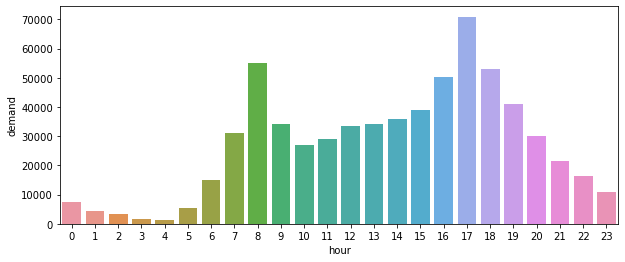

In [32]:
fig, ax = pp.subplots(figsize=(10,4))

sns.barplot(x=hourly_demand.index.get_level_values(0), y=hourly_demand["demand"],ax=ax)
pp.show()

In [33]:
#demand per weekday:
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
daily_demand = df.groupby(["weekday"]).agg(demand=("bike_id", 'count'))
daily_demand = pd.DataFrame(daily_demand)
daily_demand

,demand
weekday,
0,93097
1,100505
2,102563
3,99980
4,100904
5,81027
6,73895


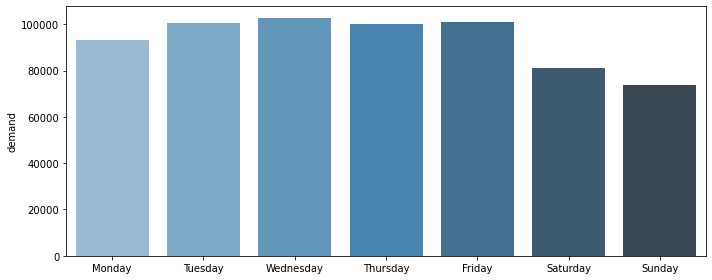

In [34]:
fig, ax = pp.subplots(figsize=(10,4))

sns.barplot(x=weekdays,y="demand",data=daily_demand, palette = 'Blues_d')
pp.tight_layout()
pp.show()

In [35]:
#calculate the monthly demand:
# different approach:
monthly_demand = df.groupby(["month"]).agg(demand=("bike_id", 'count'))
monthly_demand = pd.DataFrame(monthly_demand)
monthly_demand

,demand
month,
1,17773
2,19284
3,36102
4,42324
5,55922
6,72578
7,76215
8,77673
9,79578


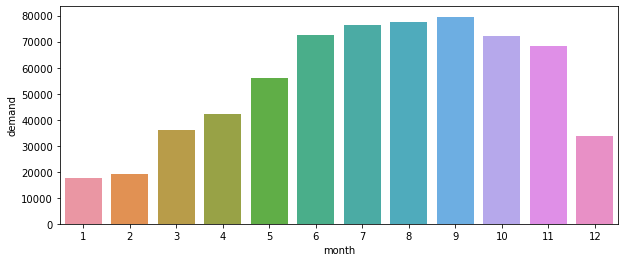

In [36]:
fig, ax = pp.subplots(figsize=(10,4))

sns.barplot(x=monthly_demand.index.get_level_values(0), y=monthly_demand["demand"],ax=ax)
pp.show()

### c) KPIs

Our first KPI is the current gross revenue which is calculated by the duration of the trip times $0,15 which is listed as the price/minute on Indego's website. We have to make some adjustments based depending on the type of pass the user has. For that we create a new dataframe only containing relevant data for us which includes the duration of the trip, the ID, the passtype, as well as some time info.

In [37]:
price_per_minute = 0.15

In [38]:
rev = df[['trip_id', 'duration', 'start_time', 'end_time', 'passholder_type', 'hour','date_hour']].copy()

In [39]:
rev.head()

,trip_id,duration,start_time,end_time,passholder_type,hour,date_hour
0,25183529,4.0,2016-07-01 00:07:00,2016-07-01 00:11:00,Indego30,0,07-01-00
1,25183528,8.0,2016-07-01 00:10:00,2016-07-01 00:18:00,Indego30,0,07-01-00
2,25183527,17.0,2016-07-01 00:11:00,2016-07-01 00:28:00,Indego30,0,07-01-00
3,25183526,25.0,2016-07-01 00:13:00,2016-07-01 00:38:00,Walk-up,0,07-01-00
4,25183525,45.0,2016-07-01 00:13:00,2016-07-01 00:58:00,Walk-up,0,07-01-00


Since we take the price per minute and the duration of the trip is in seconds, we are going to divide the duration by 60 to get it in minutes.

In [40]:
#rev["duration"] = rev["duration"]/60

In [41]:
a = rev['passholder_type'].unique()
a

array(['Indego30', 'Walk-up', 'IndegoFlex'], dtype=object)

In [42]:
rev['relevant_duration'] = rev.duration + rev.passholder_type.map( lambda x: -30 if x == 'Walk-up' else -60)

In [43]:
rev.head()

,trip_id,duration,start_time,end_time,passholder_type,hour,date_hour,relevant_duration
0,25183529,4.0,2016-07-01 00:07:00,2016-07-01 00:11:00,Indego30,0,07-01-00,-56.0
1,25183528,8.0,2016-07-01 00:10:00,2016-07-01 00:18:00,Indego30,0,07-01-00,-52.0
2,25183527,17.0,2016-07-01 00:11:00,2016-07-01 00:28:00,Indego30,0,07-01-00,-43.0
3,25183526,25.0,2016-07-01 00:13:00,2016-07-01 00:38:00,Walk-up,0,07-01-00,-5.0
4,25183525,45.0,2016-07-01 00:13:00,2016-07-01 00:58:00,Walk-up,0,07-01-00,15.0


In [44]:
rev.loc[rev.relevant_duration <= 0, "relevant_duration"] = 0

In [45]:
rev["rev_flex"] = rev["relevant_duration"] * price_per_minute

In [46]:
rev.head()

,trip_id,duration,start_time,end_time,passholder_type,hour,date_hour,relevant_duration,rev_flex
0,25183529,4.0,2016-07-01 00:07:00,2016-07-01 00:11:00,Indego30,0,07-01-00,0.0,0.00
1,25183528,8.0,2016-07-01 00:10:00,2016-07-01 00:18:00,Indego30,0,07-01-00,0.0,0.00
2,25183527,17.0,2016-07-01 00:11:00,2016-07-01 00:28:00,Indego30,0,07-01-00,0.0,0.00
3,25183526,25.0,2016-07-01 00:13:00,2016-07-01 00:38:00,Walk-up,0,07-01-00,0.0,0.00
4,25183525,45.0,2016-07-01 00:13:00,2016-07-01 00:58:00,Walk-up,0,07-01-00,15.0,2.25


In [47]:
sum(rev["rev_flex"])

624540.7500000114

In [48]:
hourly_rev = rev.groupby(["date_hour"]).agg(revenue=("rev_flex", 'sum'))
hourly_rev = pd.DataFrame(hourly_rev)
hourly_rev

,revenue
date_hour,
01-01-00,81.15
01-01-01,360.45
01-01-02,271.35
01-01-03,40.35
01-01-04,0.00
...,...
12-31-19,3.75
12-31-20,0.00
12-31-21,87.75


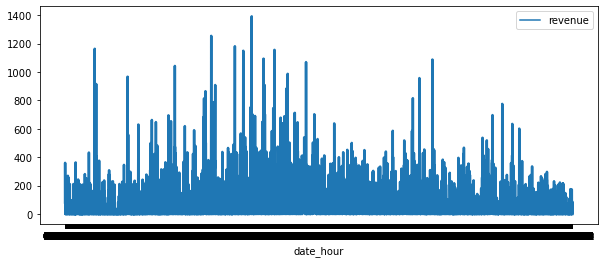

In [49]:
fig, ax = pp.subplots(figsize=(10,4))

sns.lineplot(data=hourly_rev, palette="tab10", linewidth=2.5)
pp.show()

Another KPI could be the share of walkups vs. passcard holder.

In [50]:
type_shares = df[['passholder_type', 'date_hour']].copy()

In [51]:
type_shares['type'] = type_shares.passholder_type.map( lambda x: 0 if x == 'Walk-up' else 1)

In [52]:
type_shares.head()

,passholder_type,date_hour,type
0,Indego30,07-01-00,1
1,Indego30,07-01-00,1
2,Indego30,07-01-00,1
3,Walk-up,07-01-00,0
4,Walk-up,07-01-00,0


In [53]:
hourly_share = type_shares.groupby(["date_hour", "type"]).count()
hourly_share = pd.DataFrame(hourly_share)
hourly_share

passholder_type
date_hour type                 
01-01-00  0                  11
          1                  15
01-01-01  0                  28
          1                  12
01-01-02  0                  21
...                         ...
12-31-21  0                   1
          1                  17
12-31-22  0                  13
          1                   8
12-31-23  1                  12

[15894 rows x 1 columns]

In [54]:
hourly_share_per = hourly_share.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))

In [55]:
hourly_share_per

passholder_type
date_hour type                 
01-01-00  0           42.307692
          1           57.692308
01-01-01  0           70.000000
          1           30.000000
01-01-02  0           63.636364
...                         ...
12-31-21  0            5.555556
          1           94.444444
12-31-22  0           61.904762
          1           38.095238
12-31-23  1          100.000000

[15894 rows x 1 columns]

# KPI - utilization

Aktuelle Auslastung (Live & Historisch, Pro Station) (-> Mehr Stationen, Fahrräder?) # Lukas

Aktuelle Auslastung: Heatmap / pro Tag / Station / Meistgefahrene Routen

Top Station with started Trips


In [56]:
#utilization = df.groupby(["date"]).agg(demand=("bike_id", 'count'))


In [57]:
utilization_date_id = df.groupby([df['start_time'].dt.floor(freq='D').dt.strftime('%Y-%m-%d'), "start_station_id"])['trip_id'].count()
utilization_date_id = utilization_date_id.to_frame().reset_index()
utilization_date_id

,start_time,start_station_id,trip_id
0,2016-01-01,3004,8
1,2016-01-01,3005,5
2,2016-01-01,3006,2
3,2016-01-01,3007,7
4,2016-01-01,3009,5
...,...,...,...
33067,2016-12-31,3122,2
33068,2016-12-31,3123,4
33069,2016-12-31,3124,8
33070,2016-12-31,3125,11


In [58]:
utilization_daily = df.groupby([df['start_time'].dt.floor(freq='D').dt.strftime('%Y-%m-%d')])['trip_id'].count()
utilization_daily = utilization_daily.to_frame().reset_index()
utilization_daily

,start_time,trip_id
0,2016-01-01,639
1,2016-01-02,549
2,2016-01-03,511
3,2016-01-04,672
4,2016-01-05,628
...,...,...
359,2016-12-27,1017
360,2016-12-28,1042
361,2016-12-29,682
362,2016-12-30,887


## Daily trips 01-01-2016 - 31.12.2016


[Text(0.5, 0, 'Year 2016'), [], Text(0, 0.5, 'Bike Trips')]

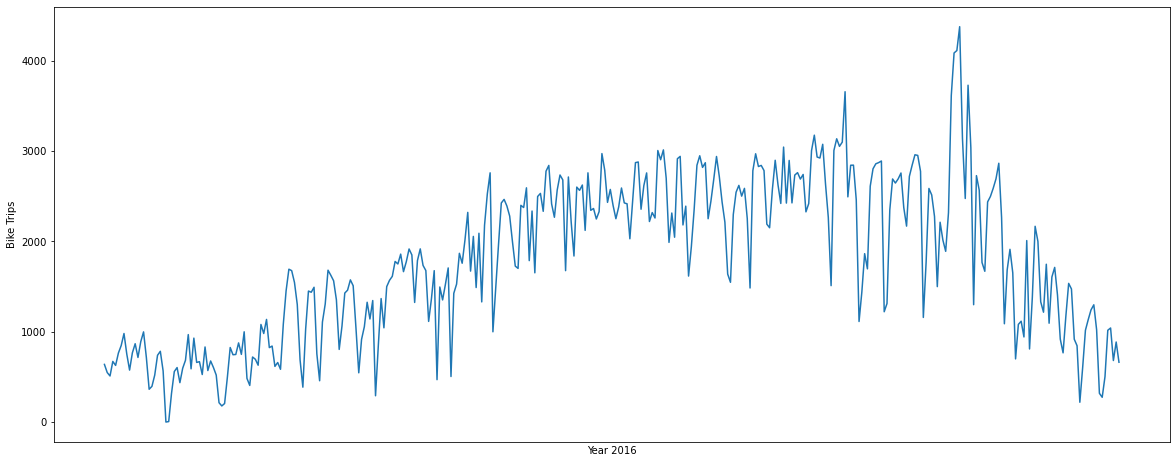

In [59]:
fig, ax = pp.subplots(figsize=(20, 8))
dailyTrips = sns.lineplot(x='start_time', y='trip_id', data=utilization_daily, ax=ax)
dailyTrips.set(xlabel='Year 2016', xticks=([]), ylabel='Bike Trips')


In [129]:
bestStations = df.groupby(["start_station_id"]).agg(demand=("trip_id", 'count')).sort_values(by='demand', ascending=False)
bestStations=bestStations.reset_index()
bestStations

,start_station_id,demand
0,3023,26024
1,3010,19680
2,3021,18434
3,3045,17770
4,3032,16899
...,...,...
101,3103,703
102,3122,667
103,3016,417
104,3117,388


In [152]:
duration = df.groupby(["start_station_id"]).agg(duration=(df["trip_id"].count(), 'mean')).sort_values(by='duration', ascending=False)
duration


KeyError: "Column '651971' does not exist!"

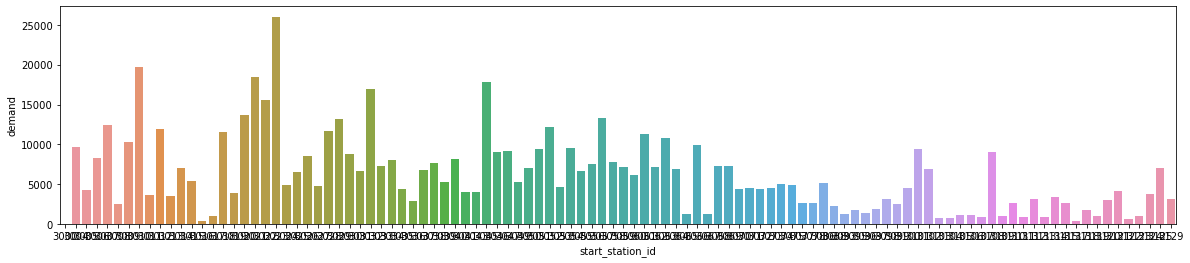

In [128]:
fig, ax = pp.subplots(figsize=(20,4))

sns.barplot(x='start_station_id', y='demand', data=bestStations ,ax=ax)
pp.show()

In [142]:
# Create a "Route ID" in the "[start_station_id]-[end_station_id]" format
route['route_id'] = df.apply(lambda x: '{0}-{1}'.format(int(x['start_station_id']), int(x['end_station_id'])), axis=1)
bestRoutes = route.value_counts().to_frame().reset_index()
bestRoutes.columns = ['route_id', 'trips']
bestRoutes = bestRoutes.loc[bestRoutes['trips'] > 10]
bestRoutes


,route_id,trips
0,3057-3057,3551
1,3020-3032,2470
2,3029-3023,1573
3,3023-3029,1519
4,3032-3020,1497
...,...,...
6356,3028-3011,11
6357,3038-3047,11
6358,3004-3106,11
6359,3077-3006,11


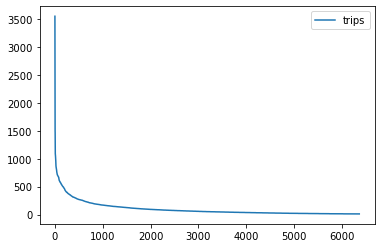

In [143]:
bestRoutes = sns.lineplot(data=bestRoutes)

